# PROBLEM STATEMENT

Your Client is an Insurance company that has provided Health Insurance to its customers, now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the Company.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay premium of certain amount to Insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called 'sum assured') to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

In [1]:
%matplotlib inline
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

In [2]:
#ignore warnings
warnings.filterwarnings('ignore')

# i. Data Wrangling

Most datasets contains dirty or missing figures, so before anything can be done, we need to clean the data.

In [3]:
#Reading the csv files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
#Creating a copy of the csv files
train_original = train.copy()
test_orginal = test.copy()

In [5]:
#Reading Submission file
submission = pd.read_csv('sample_submission_iA3afxn.csv')

In [6]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [7]:
train.isnull().sum().sum()

0

In [8]:
test.isnull().sum().sum()

0

From the above, we can see that the two datasets do not contain Nan values.

The Train dataset contains 381109 records of customers and 12 Columns (Including the TARGET VARIABLE(responses)) containing informations of the customers. The Test dataset on the other hand contains 127037 records and 11 columns(excluding the TARGET VARIABLE(responses)).

In [9]:
train.shape

(381109, 12)

In [10]:
test.shape

(127037, 11)

In [11]:
train.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

The Train dataset contains only 3 data types; Integers, objects and floats.

# ii. Exploratory Data Analysis

Now that the Datasets are Cleaned, We can perform Exploratory analysis on the datasets.

The first we will find out the Number of Customers who decided to Insure their Vehicles.

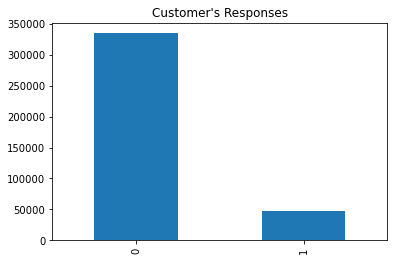

In [12]:
#Plotting the Response Column
train['Response'].value_counts().plot(kind = 'bar', title = "Customer's Responses")
plt.show()

In [13]:
train['Response'].value_counts(normalize = True)

0    0.877437
1    0.122563
Name: Response, dtype: float64

### From the Plot Above, 12%(334,399) of their Customers decided to Insure their Vehicles, while 88%(46710) refused to Insure their Vehicles.
A Majority of the Customers did not Insure their Vehicles.

Next we will be exploring the Vehicles of Customers that got Damage and how many of them decided to Insure their Vehicles

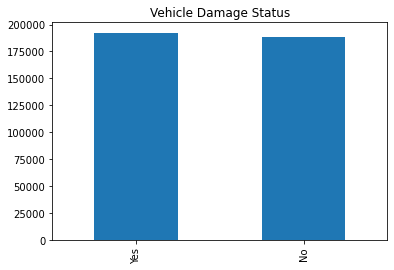

In [14]:
#Plotting Vehicle Damage Status
train['Vehicle_Damage'].value_counts().plot.bar(title = 'Vehicle Damage Status')
plt.show()

In [15]:
train['Vehicle_Damage'].value_counts(normalize = True)

Yes    0.504877
No     0.495123
Name: Vehicle_Damage, dtype: float64

From the Plot 0.504(192,413) of the Customers Vehicle are Damaged and 0.495(188,696) are not damage.

In [16]:
#Cross tabulating Vehicle_Damage and Responses
vehicle_status = pd.crosstab(train['Vehicle_Damage'], train['Response'])
vehicle_status

Response,0,1
Vehicle_Damage,,
No,187714,982
Yes,146685,45728


In [17]:
vehicle_normalised = vehicle_status.div(vehicle_status.sum(1).astype(float), axis = 0)
vehicle_normalised

Response,0,1
Vehicle_Damage,,
No,0.994796,0.005204
Yes,0.762345,0.237655


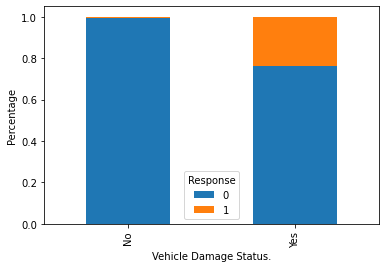

In [18]:
vehicle_normalised.plot(kind = 'bar', stacked = True)
plt.xlabel('Vehicle Damage Status.')
plt.ylabel('Percentage')
plt.show()

From the Plots 24% of Customers whose Vehicles are Damaged Opted to Insure their Vehicles while 76% didn't. Also 99% of those whose Car is not Damaged didn't opt to Insure their Vehicles.

#### We can also Infer from the Plot that Customers would rather Insure their Vehicle if it has Damage before than when it has not been Damaged Before.

We Can Also Check if the Annual Premium has an effect or Influence on Customers Decision to Insure their Vehicles.

In [19]:
#Maximum Annaul Premium
train['Annual_Premium'].max()

540165.0

In [20]:
#Minimum Annual Premium
train['Annual_Premium'].min()

2630.0

In [21]:
#Minimum Annual Premium
train['Annual_Premium'].mean()

30564.389581458323

In [22]:
#Creating a Sequence
bin = [0, 20000, 30000, 40000, 50000]
group = ['Low', 'Average', 'High', 'Very High']
train['Premium_bin'] = pd.cut(train['Annual_Premium'], bin, labels = group)
train['Premium_bin'].head()

0    Very High
1         High
2         High
3      Average
4      Average
Name: Premium_bin, dtype: category
Categories (4, object): [Low < Average < High < Very High]

In [23]:
#Cross tabulating Premium bin and Responses
Premium_bin = pd.crosstab(train['Premium_bin'], train['Response'])
Premium_bin

Response,0,1
Premium_bin,,
Low,61723,8962
Average,85817,9575
High,110055,14995
Very High,49499,8279


In [24]:
#Normalising each value(converting it to Percentage)
Premium_normalised = Premium_bin.div(Premium_bin.sum(1).astype(float), axis = 0)
Premium_normalised

Response,0,1
Premium_bin,,
Low,0.873212,0.126788
Average,0.899625,0.100375
High,0.880088,0.119912
Very High,0.856710,0.143290


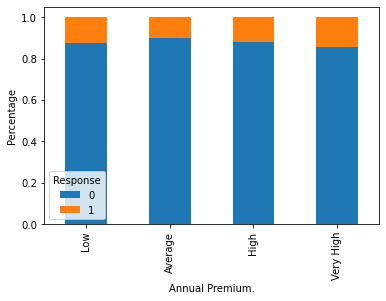

In [25]:
Premium_normalised.plot(kind = 'bar', stacked = True)
plt.xlabel('Annual Premium.')
plt.ylabel('Percentage')
plt.show()

We can Infer that Annual Premium does not Influence Customers decision on Insuring their Vehicles.

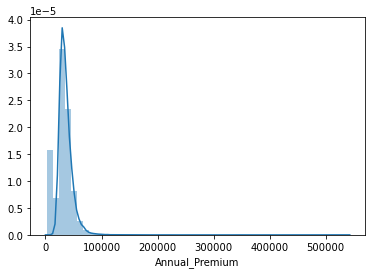

In [26]:
sns.distplot(train['Annual_Premium'])
plt.show()

From the Above we can see that more Annual premium falls between 0 to 100,000 and also Outliers are present in the data. So to take care of the Outliers we will find the Log of the values. 

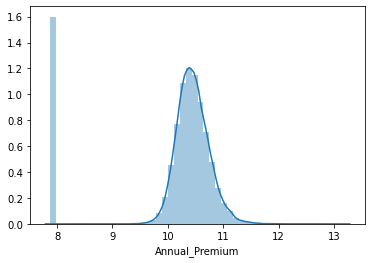

In [27]:
#Computing the Log of the Annual Premium
test['Annual_Premium'] = np.log(test['Annual_Premium'])

train['Annual_Premium'] = np.log(train['Annual_Premium'])
sns.distplot(train['Annual_Premium'])
plt.show()

This is now looks more normal than before.

### Label Encoder

In [28]:
#this fits and transforms categorical variables to digits
encoder = LabelEncoder()
train_Vehicle_age_list = [i for i in train['Vehicle_Age']]
train['Vehicle_Age'] = list(encoder.fit_transform(train_Vehicle_age_list))

test_Vehicle_age_list = [i for i in test['Vehicle_Age']]
test['Vehicle_Age'] = list(encoder.fit_transform(test_Vehicle_age_list))

In [29]:
veh_damaged = [i for i in train['Vehicle_Damage']]
train['Vehicle_Damage'] = list(encoder.fit_transform(veh_damaged))

test_veh_damaged = [i for i in test['Vehicle_Damage']]
test['Vehicle_Damage'] = list(encoder.fit_transform(test_veh_damaged))

In [30]:
gender = [i for i in train['Gender']]
train['Gender'] = list(encoder.fit_transform(gender))

test_gender = [i for i in test['Gender']]
test['Gender'] = list(encoder.fit_transform(test_gender))

# iii. Modeling

Now we can begin with the Modeling portion. First we will remove Customers id and some columns since it is not relevant to the model.

In [31]:
#dropping id, because it is not relevant to our target variable Loan Status
train = train.drop(columns = 'id', axis = 1)
test = test.drop(columns = 'id', axis = 1)
train.drop(columns = 'Premium_bin', axis = 1, inplace = True)

In [32]:
#Creating a variable containing all Independent Variables and the Target variable
x = train.drop('Response', axis = 1)
y = train.Response

## LGBM Classifier

In [33]:
#spliting the dataset
X_train, X_cv, y_train, y_cv = train_test_split(x, y, test_size = 0.25, random_state = 294)

In [34]:
model = LGBMClassifier(boosting_type = 'gbdt', n_estimators = 500, learning_rate = 0.04, objective = 'binary', is_unbalance = True, colsample_bytree = 0.5, reg_lambda = 2, reg_alpha = 2, random_state = 294, n_jobs = -1)
model

LGBMClassifier(colsample_bytree=0.5, is_unbalance=True, learning_rate=0.04,
               n_estimators=500, objective='binary', random_state=294,
               reg_alpha=2, reg_lambda=2)

In [35]:
#Fitting the model
model.fit(X_train, y_train)
#Checking the accuracy of the Prediction
pred = roc_auc_score(y_cv, model.predict_proba(X_cv)[:, 1])
f'The Accuracy of the Prediction is {pred}'

'The Accuracy of the Prediction is 0.8571331033091478'

In [36]:
#This Prints Out a Two dimensional matrix of Probabilistic values
#model.predict_proba(test)

## iv. Submission

Submission Contains the Probability that a Customer (represented with Customer ID) will choose to Insure his/her Vehicle.

In [37]:
submission['Response'] = np.array(model.predict_proba(test)[:, 1])
submission.head()

,id,Response
0,381110,0.004887
1,381111,0.773801
2,381112,0.757780
3,381113,0.032891
4,381114,0.002159


In [38]:
#reading submission Out
submission.to_csv('Vehicle_Insurance.csv', index = False)